<a href="https://colab.research.google.com/github/Dansah2/Udacity_Tutorials/blob/main/Udacity_NLP_Compare_Sentiment_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np

In [2]:
# get the dataset
dataset, info = tfds.load('glue/sst2', with_info=True)
print(info.features)

# print the number of classes
print(info.features['label'].num_classes)

# print the name of each label
print(info.features['label'].names)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/67349 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/glue/sst2/2.0.0.incompleteL6Y8Q7/glue-train.tfrecord*...:   0%|          |…

Generating validation examples...:   0%|          | 0/872 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/glue/sst2/2.0.0.incompleteL6Y8Q7/glue-validation.tfrecord*...:   0%|      …

Generating test examples...:   0%|          | 0/1821 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/glue/sst2/2.0.0.incompleteL6Y8Q7/glue-test.tfrecord*...:   0%|          | …

Dataset glue downloaded and prepared to /root/tensorflow_datasets/glue/sst2/2.0.0. Subsequent calls will reuse this data.
FeaturesDict({
    'idx': int32,
    'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    'sentence': Text(shape=(), dtype=string),
})
2
['negative', 'positive']


In [3]:
# get the training and validation data
dataset_train, dataset_validation = dataset['train'], dataset['validation']
dataset_train

<_PrefetchDataset element_spec={'idx': TensorSpec(shape=(), dtype=tf.int32, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'sentence': TensorSpec(shape=(), dtype=tf.string, name=None)}>

In [4]:
# print some of the entries in the training dataset
for example in dataset_train.take(2):
  review, label = example['sentence'], example['label']
  print(f'Review: {review}')
  print(f'Label: %d \n {label.numpy()}')

Review: b'for the uninitiated plays better on video with the sound '
Label: %d 
 0
Review: b'like a giant commercial for universal studios , where much of the action takes place '
Label: %d 
 0


In [5]:
# obtain sentences/labels for training/validation sets

training_reviews = []
training_labels = []

validation_reviews = []
validation_labels = []

# take a subset of the training reviews
for item in dataset_train.take(10000):
  review, label = item['sentence'], item['label']
  training_reviews.append(str(review.numpy()))
  training_labels.append(label.numpy())

print(f'\nNumber of training reviews is: {len(training_reviews)}')

# print some of the reviews and labels
for i in range(0, 2):
  print(training_reviews[i])
  print(training_labels[i])

# obtain all of the validation data
for item in dataset_validation.take(-1):
  review, label = item['sentence'], item['label']
  validation_reviews.append(str(review.numpy()))
  validation_labels.append(label.numpy())

print(f'\nNumber of validation reviews is: {len(validation_reviews)}')

# print some of the validation reviews
for i in range (0, 2):
  print(validation_reviews[i])
  print(validation_labels[i])


Number of training reviews is: 10000
b'for the uninitiated plays better on video with the sound '
0
b'like a giant commercial for universal studios , where much of the action takes place '
0

Number of validation reviews is: 872
b'a valueless kiddie paean to pro basketball underwritten by the nba . '
0
b"featuring a dangerously seductive performance from the great daniel auteuil , `` sade '' covers the same period as kaufmann 's `` quills '' with more unsettlingly realistic results . "
1


In [6]:
# tokenize the words an sequence the sentences

vocab_size = 4000
embedding_dem = 16
max_length = 50
trunc_type = 'post'
pad_type = 'post'
oov_tok = '<OOV>'

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_reviews)
word_index = tokenizer.word_index

In [7]:
# create training sequences then pad them
training_sequences = tokenizer.texts_to_sequences(training_reviews)
training_padded = pad_sequences(training_sequences, maxlen=max_length,
                                truncating=trunc_type, padding=pad_type)

# create validation sequences then pad them
validation_sequences = tokenizer.texts_to_sequences(validation_reviews)
validation_padded = pad_sequences(validation_sequences, maxlen=max_length)

# convert labels into numpy array
training_labels_final = np.array(training_labels)
validation_labels_final = np.array(validation_labels)

In [8]:
# create the model using an embedding
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dem, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 16)            64000     
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 64,017
Trainable params: 64,017
Non-trainable params: 0
_________________________________________________________________


In [9]:
# train the model
num_epochs = 20
history = model.fit(training_padded, training_labels_final, epochs=num_epochs,
                    validation_data=(validation_padded, validation_labels_final))

Epoch 1/20
313/313 [==============================] - 27s 68ms/step - loss: 0.6841 - accuracy: 0.5596 - val_loss: 0.6885 - val_accuracy: 0.5172
Epoch 2/20
313/313 [==============================] - 6s 18ms/step - loss: 0.6742 - accuracy: 0.5698 - val_loss: 0.6752 - val_accuracy: 0.5975
Epoch 3/20
313/313 [==============================] - 3s 8ms/step - loss: 0.6566 - accuracy: 0.6136 - val_loss: 0.6524 - val_accuracy: 0.6284
Epoch 4/20
313/313 [==============================] - 2s 7ms/step - loss: 0.6291 - accuracy: 0.6595 - val_loss: 0.6213 - val_accuracy: 0.6812
Epoch 5/20
313/313 [==============================] - 2s 7ms/step - loss: 0.5960 - accuracy: 0.7007 - val_loss: 0.5888 - val_accuracy: 0.7156
Epoch 6/20
313/313 [==============================] - 3s 9ms/step - loss: 0.5619 - accuracy: 0.7364 - val_loss: 0.5589 - val_accuracy: 0.7294
Epoch 7/20
313/313 [==============================] - 3s 8ms/step - loss: 0.5292 - accuracy: 0.7596 - val_loss: 0.5364 - val_accuracy: 0.7489
Epo

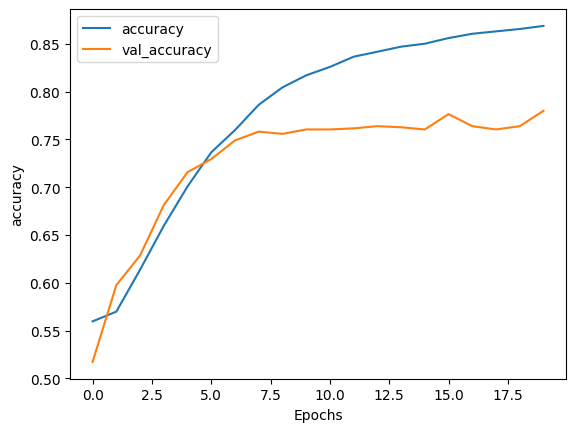

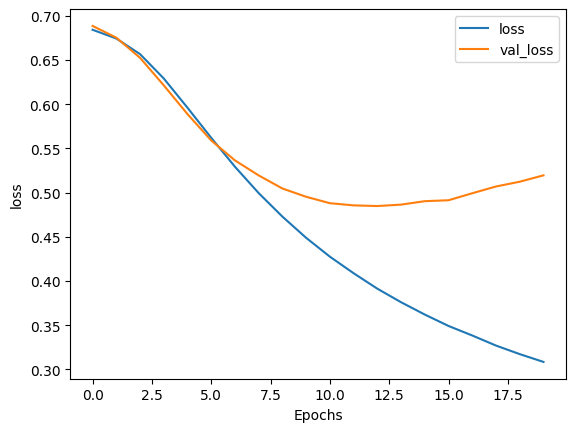

In [10]:
# plot the accuracy and loss
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel('Epochs')
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

In [11]:
# write some reveiws

review1 = """I loved this movie"""
review2 = """that was the worst movies I have ever seen"""
review3 = """too much violence even for a Bond film"""
review4 = """a capitivating recounding of a cherished myth"""
new_reviews = [review1, review2, review3, review4]

In [12]:
# define a function that prepares the reviews for use

def predict_review(model, reviews):
  # create the sequences
  padding_type = 'post'
  sample_sequences = tokenizer.texts_to_sequences(reviews)
  reviews_padded = pad_sequences(sample_sequences, padding=padding_type,
                                 maxlen=max_length)
  classes = model.predict(reviews_padded)

  for x in range(len(reviews_padded)):
    print(reviews[x])
    print(classes[x])
    print('\n')

predict_review(model, new_reviews)

1/1 [==============================] - 0s 66ms/step
I loved this movie
[0.3320076]


that was the worst movies I have ever seen
[0.0750529]


too much violence even for a Bond film
[0.02461698]


a capitivating recounding of a cherished myth
[0.3494746]




In [13]:
# define a function to train and show thr results of the model
def fit_model_and_show_results(model, reviews):
  model.summary()
  history = model.fit(training_padded, training_labels_final, epochs=num_epochs,
                      validation_data=(validation_padded, validation_labels_final))
  plot_graphs(history, 'accuracy')
  plot_graphs(history, 'loss')
  predict_review(model, reviews)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 50, 16)            64000     
                                                                 
 conv1d (Conv1D)             (None, 46, 16)            1296      
                                                                 
 global_max_pooling1d (Globa  (None, 16)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 65,313
Trainable params: 65,313
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
313/313 [==============================] - 24s 56ms/step - loss: 0.6876 - accuracy: 0.5560 - val_loss: 0.

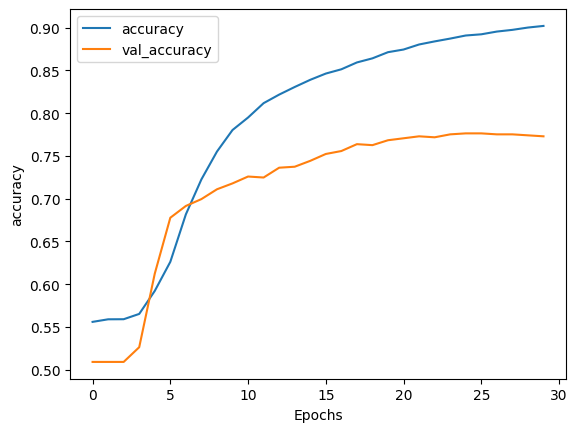

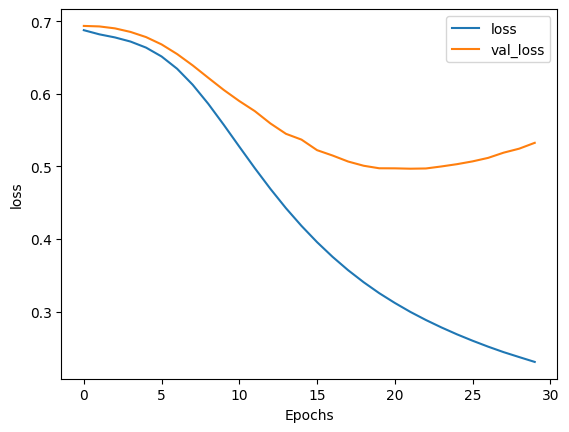

1/1 [==============================] - 0s 87ms/step
I loved this movie
[0.87285376]


that was the worst movies I have ever seen
[0.01448567]


too much violence even for a Bond film
[0.00475806]


a capitivating recounding of a cherished myth
[0.33892724]




In [14]:
# use a CNN

num_epochs = 30

model_cnn = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dem, input_length=max_length),
    tf.keras.layers.Conv1D(16, 5, activation='relu'),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

learning_rate = 0.0001

model_cnn.compile(loss='binary_crossentropy',
                  optimizer=tf.keras.optimizers.Adam(learning_rate),
                  metrics=['accuracy'])

fit_model_and_show_results(model_cnn, new_reviews)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 50, 16)            64000     
                                                                 
 bidirectional (Bidirectiona  (None, 64)               9600      
 l)                                                              
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 73,665
Trainable params: 73,665
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
313/313 [==============================] - 24s 57ms/step - loss: 0.6908 - accuracy: 0.5477 - val_loss: 0.6935 - val_accuracy: 0.5092
Epoch 2/30
313/313 [==============================] - 5s 17ms/step - loss: 0.6868 - accuracy: 0.5590 - v

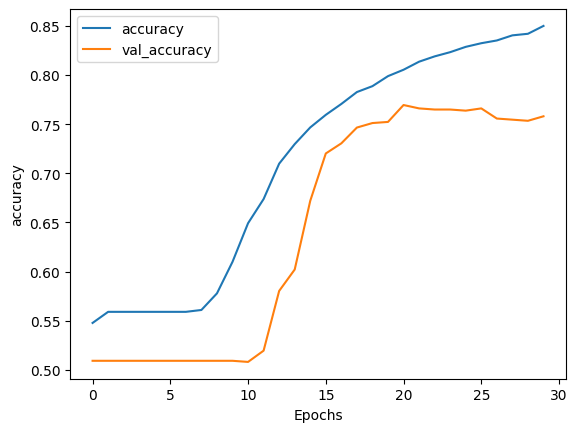

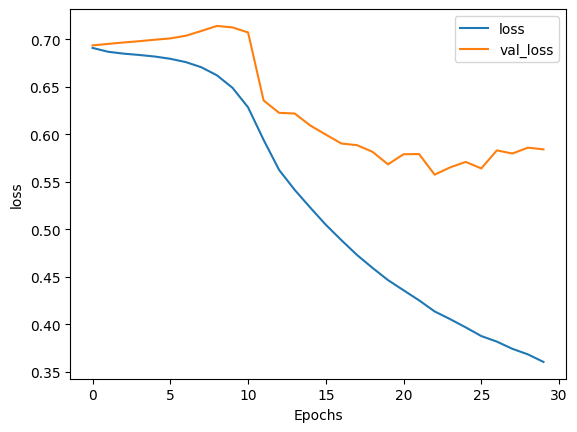

1/1 [==============================] - 1s 614ms/step
I loved this movie
[0.42137548]


that was the worst movies I have ever seen
[0.09149099]


too much violence even for a Bond film
[0.18498604]


a capitivating recounding of a cherished myth
[0.29576996]




In [15]:
# use GRU
num_epochs = 30

model_gru = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dem, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

learning_rate = 0.00003

model_gru.compile(loss='binary_crossentropy',
                  optimizer=tf.keras.optimizers.Adam(learning_rate),
                  metrics=['accuracy'])
fit_model_and_show_results(model_gru, new_reviews)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 50, 16)            64000     
                                                                 
 bidirectional_1 (Bidirectio  (None, 32)               4224      
 nal)                                                            
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 68,257
Trainable params: 68,257
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
313/313 [==============================] - 27s 69ms/step - loss: 0.6904 - accuracy: 0.5591 - val_loss: 0.6929 - val_accuracy: 0.5092
Epoch 2/30
313/313 [==============================] - 6s 18ms/step - loss: 0.6870 - accuracy: 0.5590 - v

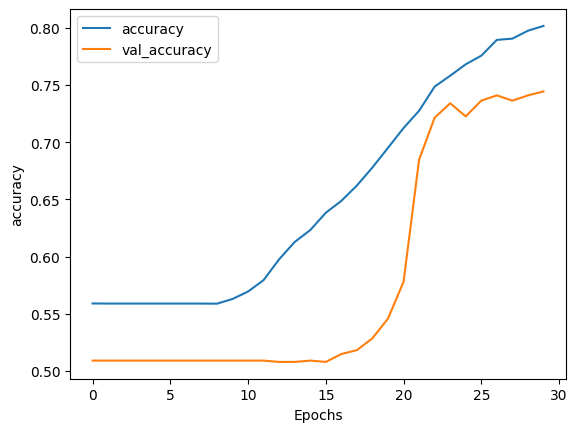

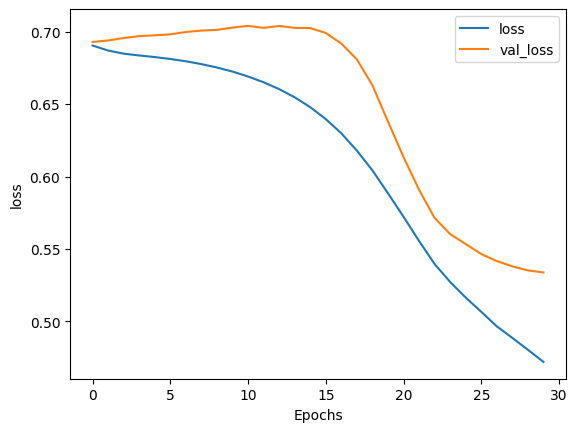

1/1 [==============================] - 1s 689ms/step
I loved this movie
[0.4562201]


that was the worst movies I have ever seen
[0.24299553]


too much violence even for a Bond film
[0.4265019]


a capitivating recounding of a cherished myth
[0.41558963]




In [16]:
# Bidirectional LSTM

num_epochs = 30

model_bidi_lstm = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dem, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dem)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

learning_rate = 0.00003

model_bidi_lstm.compile(loss='binary_crossentropy',
                        optimizer=tf.keras.optimizers.Adam(learning_rate),
                        metrics=['accuracy'])

fit_model_and_show_results(model_bidi_lstm, new_reviews)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 50, 16)            64000     
                                                                 
 bidirectional_2 (Bidirectio  (None, 50, 32)           4224      
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 32)               6272      
 nal)                                                            
                                                                 
 dense_4 (Dense)             (None, 1)                 33        
                                                                 
Total params: 74,529
Trainable params: 74,529
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
313/313 [==============================

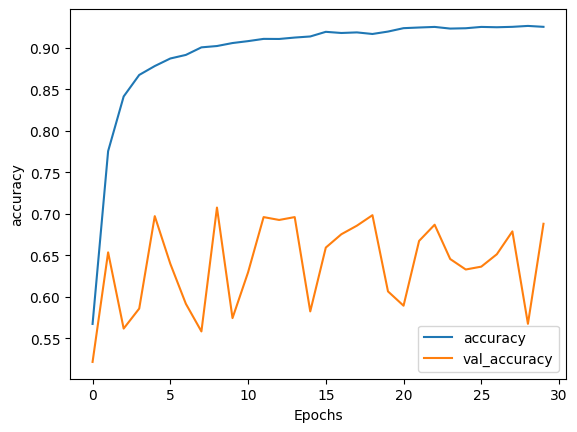

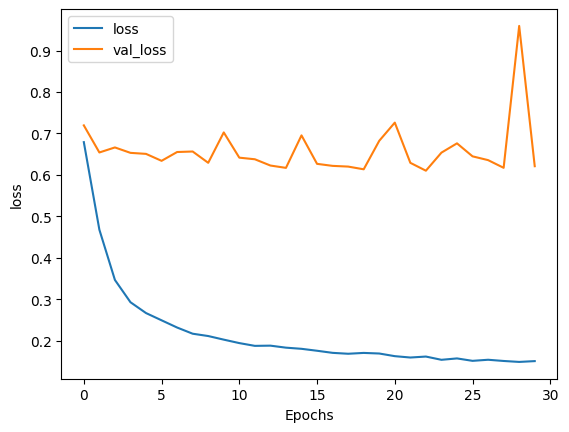

1/1 [==============================] - 1s 1s/step
I loved this movie
[0.751345]


that was the worst movies I have ever seen
[0.44771406]


too much violence even for a Bond film
[0.01252654]


a capitivating recounding of a cherished myth
[0.02114155]




In [18]:
# multiple Bidirectional LSTMs
num_epochs = 30

model_multi_bidi_lstm = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dem, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dem, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dem)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

learning_rate = 0.0003

model_multi_bidi_lstm.compile(loss='binary_crossentropy',
                              optimizer=tf.keras.optimizers.Adam(learning_rate),
                              metrics=['accuracy'])
fit_model_and_show_results(model_multi_bidi_lstm, new_reviews)

In [19]:
# try more reviews

review1 = 'I loved this movie'

review2 = 'that was the worst movie I have ever seen'

review3 = 'too much violence even for a Bond film'

review4 = 'a captivating recounting of a cherished myth'

review5 = """I saw this movie yesterday and I was feeling low to start with,
but it was such a wonderful movie that it lifted my spirits and brightened
my day, you cannot go wrong with a movie with Whoopi Goldberg in it."""

review6 = """I  don\'t understand why it received a oscar reccomendation
for best movie, it was long and boring"""

review7 = """the scenery was magnificent, the CGI of the dogs was so realistic I
thought they were played by real dogs even though they talked!"""

review8 = """The ending was so sad and yet so uplifting at the same time.
I'm looking for an excuse to see it again"""

review9= """I had expected so much more from a movie made by the director
who made my most favorite movie ever, I was very disappointed in the tedious story"""

review10 = 'I wish I could watch this movie every day for the rest of my life'

more_reviews = [review1, review2, review3, review4, review5, review6, review7, review8, review9, review10]

In [20]:
print('==========================\n', 'Embeddings only:\n', '=============================')
predict_review(model, more_reviews)

 Embeddings only:
1/1 [==============================] - 0s 22ms/step
I loved this movie
[0.3320076]


that was the worst movie I have ever seen
[0.04537041]


too much violence even for a Bond film
[0.02461698]


a captivating recounting of a cherished myth
[0.55059326]


I saw this movie yesterday and I was feeling low to start with,
but it was such a wonderful movie that it lifted my spirits and brightened
my day, you cannot go wrong with a movie with Whoopi Goldberg in it.
[0.25961632]


I  don't understand why it received a oscar reccomendation
for best movie, it was long and boring
[0.12689148]


the scenery was magnificent, the CGI of the dogs was so realistic I
thought they were played by real dogs even though they talked!
[0.22031696]


The ending was so sad and yet so uplifting at the same time.
I'm looking for an excuse to see it again
[0.45793045]


I had expected so much more from a movie made by the director
who made my most favorite movie ever, I was very disappointed in

In [21]:
print('==========================\n', 'With CNN\n', '=============================')
predict_review(model_cnn, more_reviews)

 With CNN
1/1 [==============================] - 0s 47ms/step
I loved this movie
[0.87285376]


that was the worst movie I have ever seen
[0.00800008]


too much violence even for a Bond film
[0.00475806]


a captivating recounting of a cherished myth
[0.68510735]


I saw this movie yesterday and I was feeling low to start with,
but it was such a wonderful movie that it lifted my spirits and brightened
my day, you cannot go wrong with a movie with Whoopi Goldberg in it.
[0.2683862]


I  don't understand why it received a oscar reccomendation
for best movie, it was long and boring
[0.658749]


the scenery was magnificent, the CGI of the dogs was so realistic I
thought they were played by real dogs even though they talked!
[0.22253844]


The ending was so sad and yet so uplifting at the same time.
I'm looking for an excuse to see it again
[0.65753776]


I had expected so much more from a movie made by the director
who made my most favorite movie ever, I was very disappointed in the tedio

In [22]:
print('==========================\n', 'With Bidirectional GRU\n', '=============================')
predict_review(model_gru, more_reviews)

 With Bidirectional GRU
1/1 [==============================] - 0s 23ms/step
I loved this movie
[0.42137548]


that was the worst movie I have ever seen
[0.08092967]


too much violence even for a Bond film
[0.18498604]


a captivating recounting of a cherished myth
[0.46035838]


I saw this movie yesterday and I was feeling low to start with,
but it was such a wonderful movie that it lifted my spirits and brightened
my day, you cannot go wrong with a movie with Whoopi Goldberg in it.
[0.10395519]


I  don't understand why it received a oscar reccomendation
for best movie, it was long and boring
[0.06898593]


the scenery was magnificent, the CGI of the dogs was so realistic I
thought they were played by real dogs even though they talked!
[0.13289203]


The ending was so sad and yet so uplifting at the same time.
I'm looking for an excuse to see it again
[0.36532873]


I had expected so much more from a movie made by the director
who made my most favorite movie ever, I was very disappoi

In [23]:
print('==========================\n', 'Single Bidirectional LSTM\n', '=============================')
predict_review(model_bidi_lstm, more_reviews)

 Single Bidirectional LSTM
1/1 [==============================] - 0s 24ms/step
I loved this movie
[0.4562201]


that was the worst movie I have ever seen
[0.21182099]


too much violence even for a Bond film
[0.4265019]


a captivating recounting of a cherished myth
[0.46108034]


I saw this movie yesterday and I was feeling low to start with,
but it was such a wonderful movie that it lifted my spirits and brightened
my day, you cannot go wrong with a movie with Whoopi Goldberg in it.
[0.23137341]


I  don't understand why it received a oscar reccomendation
for best movie, it was long and boring
[0.20573533]


the scenery was magnificent, the CGI of the dogs was so realistic I
thought they were played by real dogs even though they talked!
[0.22862102]


The ending was so sad and yet so uplifting at the same time.
I'm looking for an excuse to see it again
[0.26980188]


I had expected so much more from a movie made by the director
who made my most favorite movie ever, I was very disappo

In [24]:
print('==========================\n', 'Multi Bidirectional LSTM\n', '=============================')
predict_review(model_multi_bidi_lstm, more_reviews)

 Multi Bidirectional LSTM
1/1 [==============================] - 0s 23ms/step
I loved this movie
[0.751345]


that was the worst movie I have ever seen
[0.42129403]


too much violence even for a Bond film
[0.01252654]


a captivating recounting of a cherished myth
[0.9957789]


I saw this movie yesterday and I was feeling low to start with,
but it was such a wonderful movie that it lifted my spirits and brightened
my day, you cannot go wrong with a movie with Whoopi Goldberg in it.
[0.29319975]


I  don't understand why it received a oscar reccomendation
for best movie, it was long and boring
[0.0216638]


the scenery was magnificent, the CGI of the dogs was so realistic I
thought they were played by real dogs even though they talked!
[0.9953414]


The ending was so sad and yet so uplifting at the same time.
I'm looking for an excuse to see it again
[0.99075633]


I had expected so much more from a movie made by the director
who made my most favorite movie ever, I was very disappointe